# Final filtering with AF2

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders
dig99


### Run AF2 on the sequences

In [3]:
from pyrosetta.distributed.packed_pose.core import PackedPose


def predict_chA(packed_pose_in=None, **kwargs) -> PackedPose:
    """
    Generate a fasta of chain A only. Predict with AF2.
    Load prediction and compute LDDT and RMSD to chA
    """
    import binascii, bz2, os, subprocess
    from glob import glob
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed import cluster
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    def cmd(command, wait=True):
        """@nrbennet @bcov"""
        the_command = subprocess.Popen(
            command,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            universal_newlines=True,
        )
        if not wait:
            return
        the_stuff = the_command.communicate()
        return str(the_stuff[0]) + str(the_stuff[1])

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = dict(pyrosetta.distributed.cluster.get_scores_dict(file)["scores"])
    else:
        raise RuntimeError("Need to supply an input")

    pose = io.to_pose(ppose)

    if kwargs["out_path"] == None:
        out_path = os.getcwd()
    else:
        out_path = kwargs["out_path"]
        os.makedirs(os.path.join(os.getcwd(), out_path), exist_ok=True)

    xml_string = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <SwitchChainOrder name="A_only" chain_order="1"/>
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add mover="A_only" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """
    chA_only = SingleoutputRosettaScriptsTask(xml_string)
    chA = chA_only(pose.clone())
    sequence = chA.pose.sequence()
    file_handle = binascii.b2a_hex(os.urandom(15)).decode("ascii")
    with open(os.path.join(os.getcwd(), out_path, file_handle), "w+") as f:
        print(">" + file, file=f)
        print(sequence, file=f)
    # run AF2
    python = "/software/conda/envs/SE3/bin/python"
    af2 = "/projects/ml/alphafold/alphafold_git/predict_single_seq.py"
    fasta = os.path.join(os.getcwd(), out_path, file_handle)
    command = f"{python} {af2} {fasta} {fasta}"
    print(command)
    out = cmd(command)
    lines = list(iter(out.splitlines()))
    for line in lines:
        if "lDDT" in line:
            lddt_af2 = float(line.split()[-1])
            break
        else:
            pass

    # get lddt design, prediction
    design = os.path.join(os.getcwd(), out_path, file_handle + ".pdb")
    chA.pose.dump_pdb(design)
    lddt_path = "/home/aivan/prog/lddt-linux/lddt"
    command = f"{lddt_path} {design} {fasta}_unrelaxed_model_4.pdb"
    print(command)
    out = cmd(command)
    lines = list(iter(out.splitlines()))
    for line in lines:
        if "Global" in line:
            lddt_des_pred_X = float(line.split()[-1])
            break
        else:
            pass
    # get rmsd to design
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    chA = io.to_pose(chA)
    rmsd_calc.set_comparison_pose(chA)
    pred_pose = io.to_pose(io.pose_from_file(f"{fasta}_unrelaxed_model_4.pdb"))
    rmsd = rmsd_calc.calculate(pred_pose)
    scores["lddt_af2_X"] = lddt_af2
    scores["lddt_des_pred_X"] = lddt_des_pred_X
    scores["rmsd_pred_X"] = rmsd
    scores["pred_prefix"] = fasta

    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    ppose = io.to_packed(pose)
    return ppose

### Setup dask, set command line options, make tasks and submit to client for predictions

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "06_score_dslf/best_deltas.list")
options = {}


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for file in f:
            tasks = {"options": ""}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            tasks["out_path"] = f"07_predictions"
            yield tasks


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

output_path = os.path.join(os.getcwd(), "07_predict_chA")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="7GB",
        queue="backfill",
        walltime="11:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "10h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[predict_chA])

### Look at scores
Hacky function to load JSON-like data

In [3]:
def read_scorefile(scores):
    import pandas as pd
    from tqdm import tqdm

    dfs = []
    with open(scores, "r") as f:
        for line in tqdm(f):
            dfs.append(pd.read_json(line).T)
    tabulated_scores = pd.concat(dfs)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "07_predict_chA")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

938it [00:11, 78.42it/s]


,9mer_X,9mer_Y,X_nocys_path,X_path,X_seq,Y_nocys_path,Y_path,Y_seq,abego_str_Y,ala_penalty,...,total_score_Y,twosided_Y_resis,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y,cart_bonded_Y,coordinate_constraint_Y
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/07_predict_chA/decoys/0000/2021.07.22.21.49.21.963429_e188072e975f454db4a63847d8a0fc86.pdb.bz2,0.432344,2.428196,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMELLKKAVELAKKNNDDEVARIIEEAAKRIVEALRETDSS...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMELLKKAVELAKKNNDDEVARIIEEAAKRIVEALRETDSS...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,1.0,...,-670.46051,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.407441,0.587284,0.114117,0.109675,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/07_predict_chA/decoys/0000/2021.07.22.21.49.21.963429_5cd02fa0f6a04733b8769ed027323ea2.pdb.bz2,0.432344,2.442451,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEALKKAVELAKKNNDDEVAREIERAAKEIVEALRETRSS...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEALKKAVELAKKNNDDEVAREIERAAKEIVEALRETRSS...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,1.0,...,-678.648865,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.467193,0.582087,0.095464,0.108823,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/07_predict_chA/decoys/0000/2021.07.22.21.49.21.963429_07cda7a27dec4b7793408c4981a2c2a0.pdb.bz2,0.432344,2.472573,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEALKKAVELAKKNNDDEVARVIERVAKEIVEALRELRSP...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEALKKAVELAKKNNDDEVARVIERVAKEIVEALRELRSP...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,2.0,...,-672.294128,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.476162,0.491647,0.111455,0.134895,64.695625,84.301338
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/07_predict_chA/decoys/0000/2021.07.22.21.49.21.963429_8b852f8a4077424a8f8fcd6dc783bbec.pdb.bz2,0.432344,2.428196,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEVLKKAVELAKKNNDDEVARTIERVAKEIVEALRETRSE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DEMKKVMEVLKKAVELAKKNNDDEVARTIERVAKEIVEALRETRSE...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,1.0,...,-671.651001,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.411031,0.578473,0.101682,0.112785,NaN,NaN
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/07_predict_chA/decoys/0000/2021.07.22.21.49.21.963429_a90accf8fe8d42149dbe6647c8648c2a.pdb.bz2,0.370115,3.594173,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEEVNERVKQLAEKAKEATDKEEVIEIVKELAELAKQSTDSRLVKE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEEVNERVKQLAEKAKEATDKEEVIEIVKELAELAKQSTDSRLVKE...,XAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABABAAAAAA...,1.0,...,-574.114075,"False,False,False,False,False,False,False,Fals...",0.0,0.0,0.316191,0.327669,0.102557,0.119914,NaN,NaN


In [4]:
scores_df.to_json(os.path.join(output_path, "scores_pd.json"))

In [5]:
scores_df = pd.read_json(os.path.join(output_path, "scores_pd.json"), dtype=float)

### Plot AF2 and lDDT scores

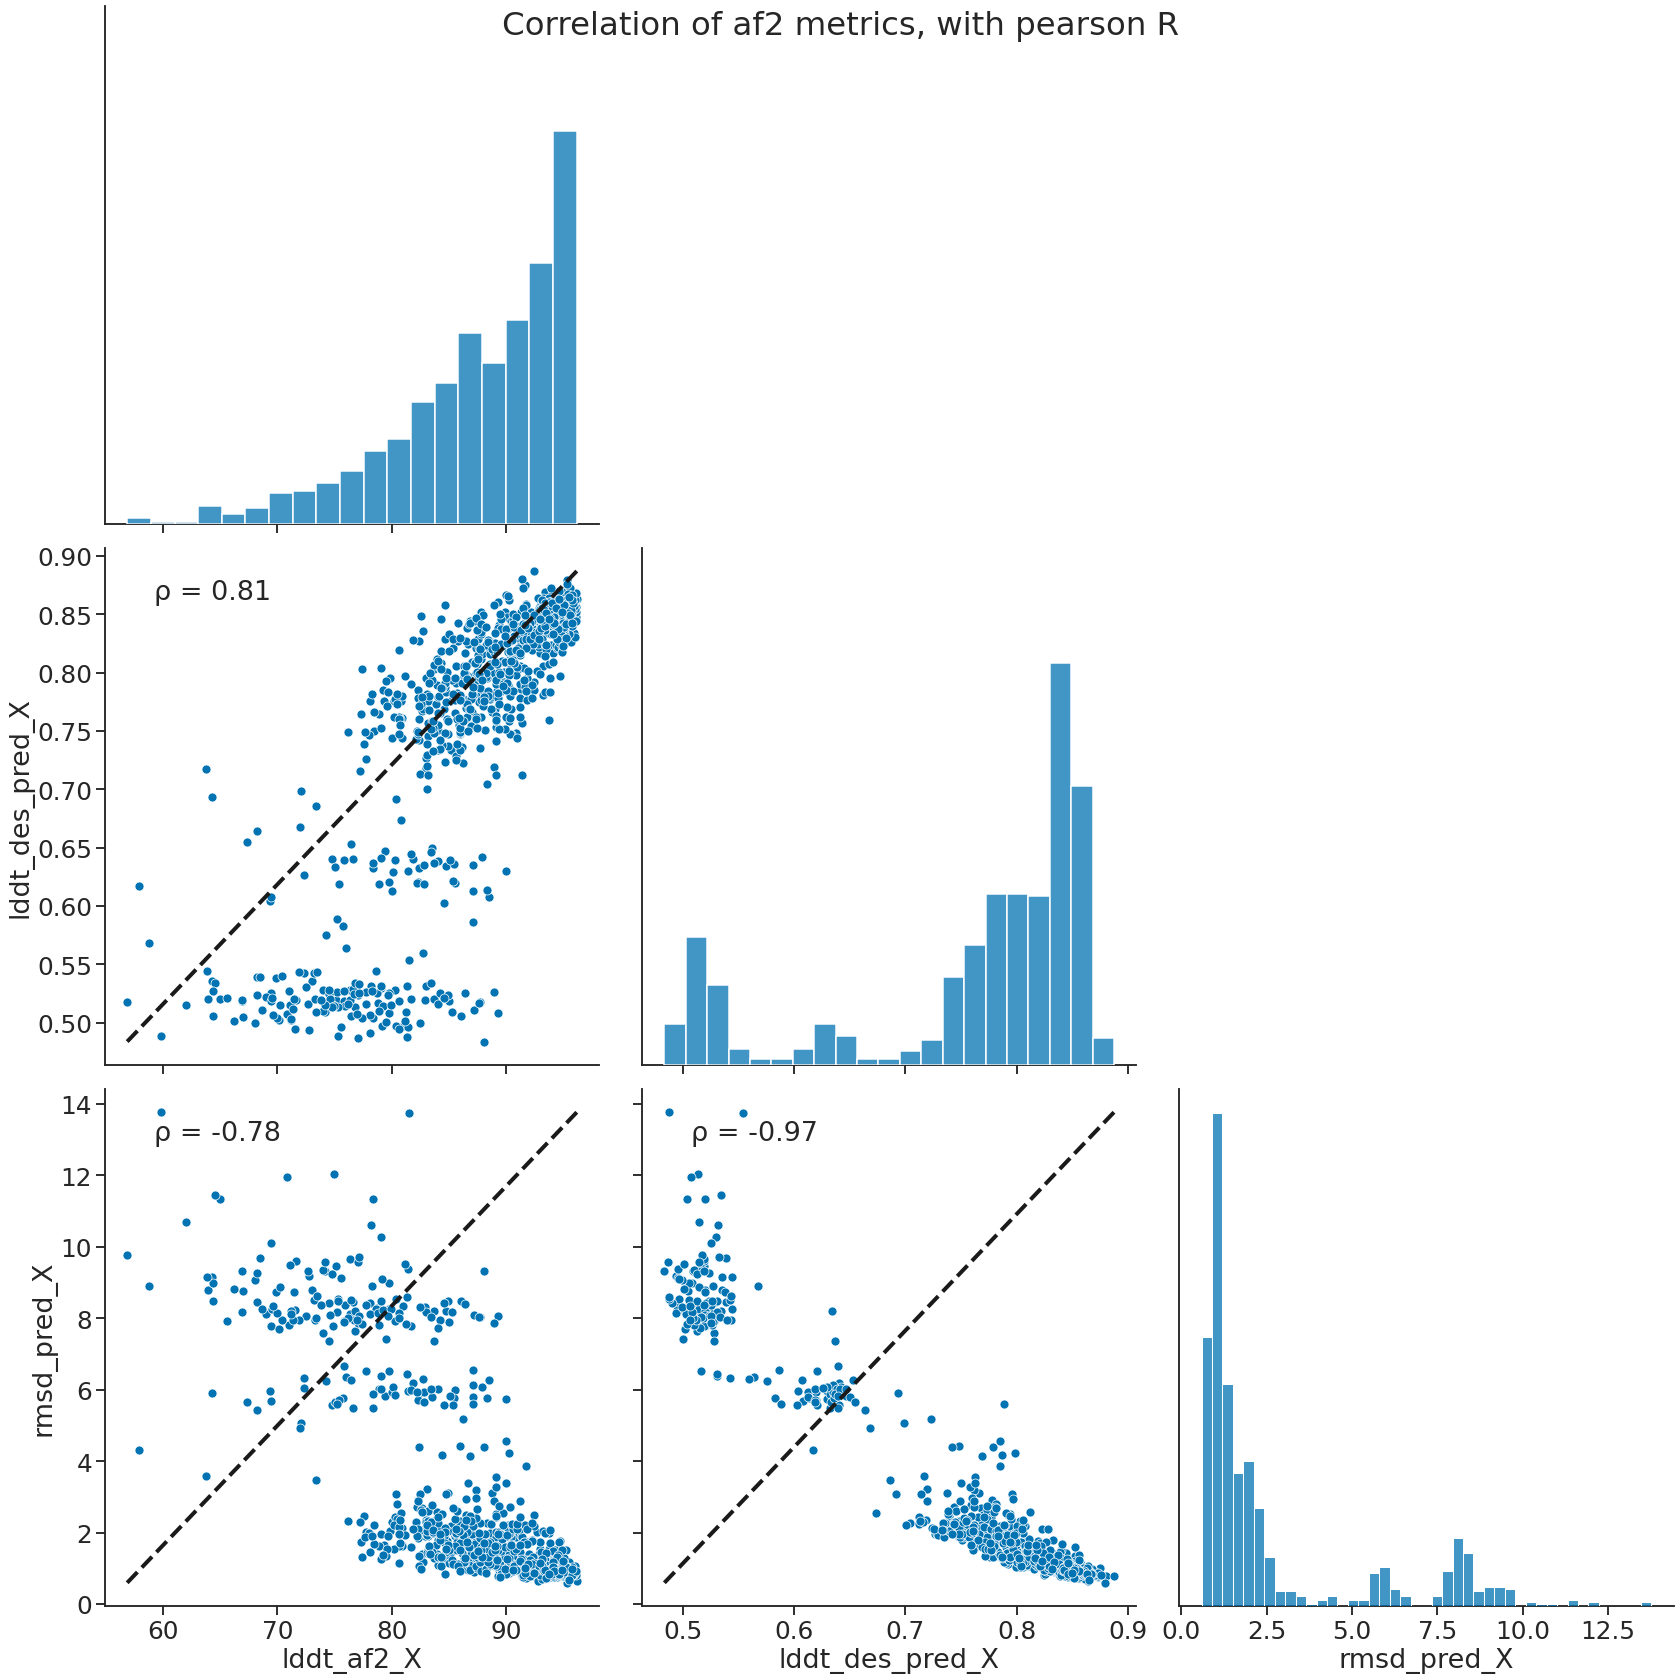

In [6]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)


def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


subset = scores_df[
    [
        "lddt_af2_X",
        "lddt_des_pred_X",
        "rmsd_pred_X",
        "parent",
    ]
]

ax = sns.pairplot(data=subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of af2 metrics, split by parent")
sns.despine()
plt.savefig("figs/07_correlations_af2_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=subset, corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of af2 metrics, with pearson R")
sns.despine()
plt.savefig("figs/07_correlations_af2_pearson.png")

### Select subset that is predicted to fold close to accurate

In [7]:
def row2state(row):
    state = (
        row["parent"]
        + "_p_"
        + str(int(row["pivot_helix"]))
        + "_s_"
        + str(int(row["shift"]))
        + "_d_"
        + str(int(row["docked_helix_Y"]))
    )
    return state


scores_df["state"] = scores_df.apply(row2state, axis=1)
good = scores_df[scores_df["rmsd_pred_X"] < 2]
good = good[good["lddt_af2_X"] > 80]

print(len(set(good.state.values)))
print(len(good))
print(len(set(good.parent.values)))
set(scores_df.parent.values) - set(good.parent.values)

30
600
15


set()

### Write a list of the ones that pass decent AF2 cutoffs

In [8]:
with open(os.path.join(os.getcwd(), "07_predict_chA", "good_rmsd.list"), "w") as f:
    for i in good.index:
        print(i, file=f)

### For the 30 states that are predicted to fold, get the top 2 in terms of RMSD
(or top if there is only 1 state)

In [10]:
unique_states = set(good.state.values)
best_rmsd = []
for state in unique_states:
    temp_df = good[good["state"] == state]
    if len(temp_df) <= 2:
        best_rmsd.extend(list(temp_df.index))
    else:
        temp_df = temp_df.sort_values("rmsd_pred_X")
        best_rmsd.extend(list(temp_df.index)[:2])
print(f"{len(best_rmsd)} designs selected")
with open(os.path.join(os.getcwd(), "07_predict_chA", "best_rmsd.list"), "w") as f:
    for i in best_rmsd:
        print(i, file=f)

55 designs selected


### Now try to max binding metrics

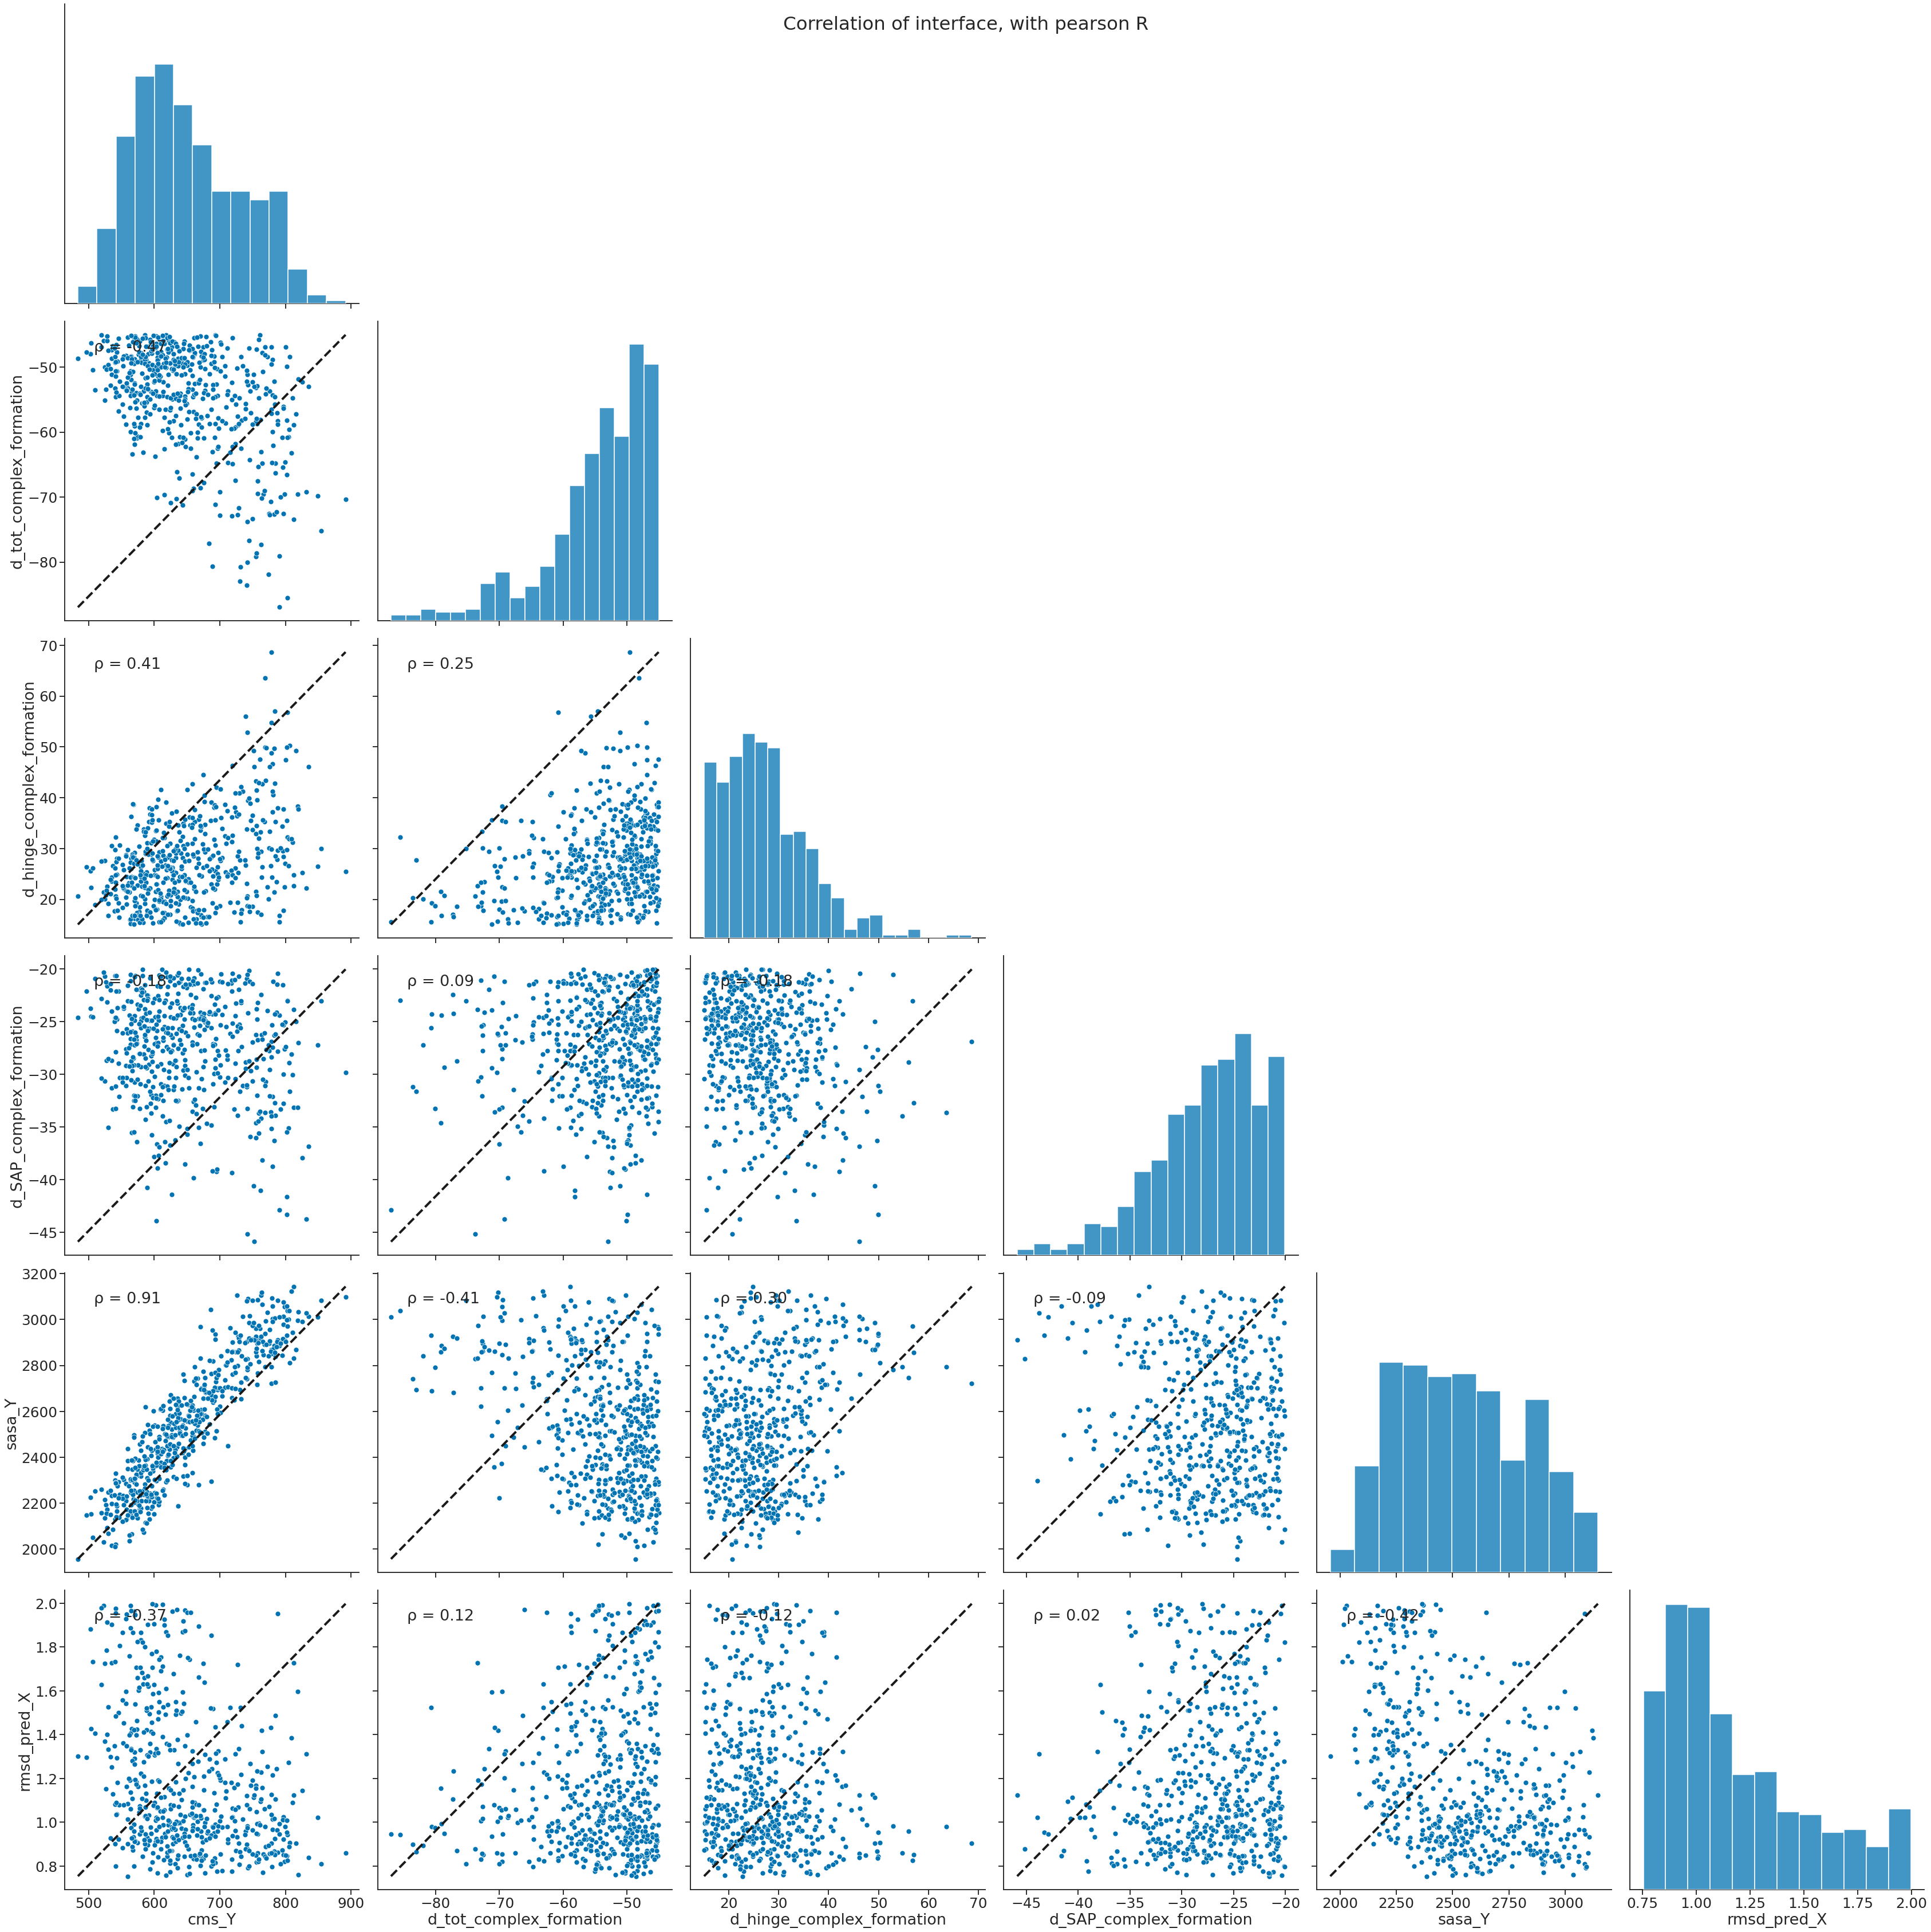

In [12]:
best_minus55 = good.loc[[i for i in good.index if i not in best_rmsd]]

best_minus55["d_tot_complex_formation"] = best_minus55["tot_score_Y"] - (
    best_minus55["tot_score_A"] + best_minus55["tot_score_B"]
)
best_minus55["d_hinge_complex_formation"] = (
    best_minus55["tot_score_C"] - best_minus55["tot_score_A"]
)

best_minus55["d_SAP_complex_formation"] = best_minus55["sap_Y"] - (
    best_minus55["sap_A"] + best_minus55["sap_B"]
)
best_minus55["d_hinge_SAP_complex_formation"] = (
    best_minus55["sap_C"] - best_minus55["sap_A"]
)


subset = best_minus55[
    [
        "cms_Y",
        "d_tot_complex_formation",
        "d_hinge_complex_formation",
        "d_SAP_complex_formation",
        "sasa_Y",
        "rmsd_pred_X",
        "parent",
    ]
]

ax = sns.pairplot(data=subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of interface metrics, split by parent")
sns.despine()
plt.savefig("figs/07_correlations_interface_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=subset, corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of interface, with pearson R")
sns.despine()
plt.savefig("figs/07_correlations_interface_pearson.png")

### Filter even more stringently

In [13]:
excellent = best_minus55[best_minus55["rmsd_pred_X"] < 1.2]
excellent = excellent[excellent["lddt_af2_X"] > 85]
excellent = excellent[excellent["d_SAP_complex_formation"] < -25]
excellent = excellent[excellent["d_tot_complex_formation"] < -50]
excellent = excellent[excellent["cms_Y"] > 600]

print(len(set(excellent.state.values)))
print(len(excellent))
print(len(set(excellent.parent.values)))
set(best_minus55.parent.values) - set(excellent.parent.values)

13
126
8


{'DHR07_nocys', 'DHR76', 'hDHR9_HFuse'}

### Get best delta SAP designs

In [14]:
unique_states = set(excellent.state.values)
best_d_SAP = []
for state in unique_states:
    temp_df = excellent[excellent["state"] == state]
    if len(temp_df) <= 2:
        best_d_SAP.extend(list(temp_df.index))
    else:
        temp_df = temp_df.sort_values("d_SAP_complex_formation")
        best_d_SAP.append(list(temp_df.index)[0])
print(f"{len(best_d_SAP)} designs selected")
with open(os.path.join(os.getcwd(), "07_predict_chA", "best_d_SAP.list"), "w") as f:
    for i in best_d_SAP:
        print(i, file=f)

15 designs selected


### Get best delta total score designs

In [15]:
excellent = excellent.loc[[i for i in excellent.index if i not in best_d_SAP]]

unique_states = set(excellent.state.values)
best_d_tot = []
for state in unique_states:
    temp_df = excellent[excellent["state"] == state]
    if len(temp_df) <= 2:
        best_d_tot.extend(list(temp_df.index))
    else:
        temp_df = temp_df.sort_values("d_tot_complex_formation")
        best_d_tot.append(list(temp_df.index)[0])
print(f"{len(best_d_tot)} designs selected")
with open(os.path.join(os.getcwd(), "07_predict_chA", "best_d_tot.list"), "w") as f:
    for i in best_d_tot:
        print(i, file=f)

10 designs selected


### Get best cms score designs

In [16]:
excellent = excellent.loc[[i for i in excellent.index if i not in best_d_tot]]

unique_states = set(excellent.state.values)
best_cms = []
for state in unique_states:
    temp_df = excellent[excellent["state"] == state]
    if len(temp_df) <= 2:
        best_cms.extend(list(temp_df.index))
    else:
        temp_df = temp_df.sort_values("cms_Y")
        best_cms.append(list(temp_df.index)[0])
print(f"{len(best_cms)} designs selected")
with open(os.path.join(os.getcwd(), "07_predict_chA", "best_cms.list"), "w") as f:
    for i in best_cms:
        print(i, file=f)

6 designs selected


### Get 22 more designs
we'll take them from hDHR76 and hDHR79

In [17]:
excellent = excellent.query(
    "state == 'hDHR76_5CWO_p_4_s_3_d_3' | state == 'hDHR79_5CWP_p_4_s_3_d_3'"
)
extra = excellent.sample(22, random_state=0)
with open(os.path.join(os.getcwd(), "07_predict_chA", "best_extra.list"), "w") as f:
    for i in extra.index:
        print(i, file=f)

In [18]:
to_order = []
for best_list in glob(os.path.join(os.getcwd(), "07_predict_chA", "best*.list")):
    with open(best_list, "r") as f:
        for line in f:
            to_order.append(line.rstrip())
len(to_order)

108

### Concatenate all selected

In [2]:
order_df = scores_df.loc[to_order]
order_df.index.name = "abspath"
names = [f"cs_{(str(i)).zfill(3)}" for i in range(1, 109)]
order_df["ordered_name"] = names
order_df.reset_index(inplace=True)
order_df.set_index("ordered_name", inplace=True)
os.makedirs(os.path.join(os.getcwd(), "07_to_order"), exist_ok=True)
order_df.to_json(os.path.join(os.getcwd(), "07_to_order", "final_scores.json"))

NameError: name 'scores_df' is not defined

In [3]:
s1 = order_df.loc["cs_001"]["final_sequence"]
print(s1)
print(order_df.loc["cs_001"]["abspath"])

NameError: name 'order_df' is not defined

In [4]:
def row2chA_seq(row):
    from itertools import compress
    
    chA_seq = "".join(list(compress(row["final_sequence"], list(row["chC_resis"]))))
    return chA_seq

def row2chB_seq(row):
    from itertools import compress
    
    chB_seq = "".join(list(compress(row["final_sequence"], list(row["chD_resis"]))))
    return chB_seq
    
order_df["chA_seq"] = order_df.apply(row2chA_seq, axis=1)
order_df["chB_seq"] = order_df.apply(row2chB_seq, axis=1)

print(order_df.loc["cs_001"]["chA_seq"])
print(order_df.loc["cs_001"]["chB_seq"])

NameError: name 'order_df' is not defined

### Unused blocks

In [32]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

# flags = """
# -holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
# -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
# """
# pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
pyrosetta.distributed.init()
t = predict_chA(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/06_score_dslf/decoys/0000/2021.07.19.22.26.08.731625_6e1e66d90c364051ae9e07bf5e28a9e1.pdb.bz2",
        "out_path": "test",
    }
)

core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue GLU:CtermProteinFull 177
CPU times: user 3.7 s, sys: 43 ms, total: 3.74 s
Wall time: 2min 39s
